In [1]:
using Images
using PyPlot
using FileIO
using Optim
using Random
using Statistics

include("Common.jl")

Main.Common

In [2]:
#---------------------------------------------------------
# Load features and labels from file.
#---------------------------------------------------------
function loaddata(path::String)
  features = load(path,"features")
  labels = load(path,"labels")
  @assert length(labels) == size(features,1)
  return features::Array{Float64,2}, labels::Array{Float64,1}
end

# load linear separable data
features,labels = loaddata("separable.jld2");

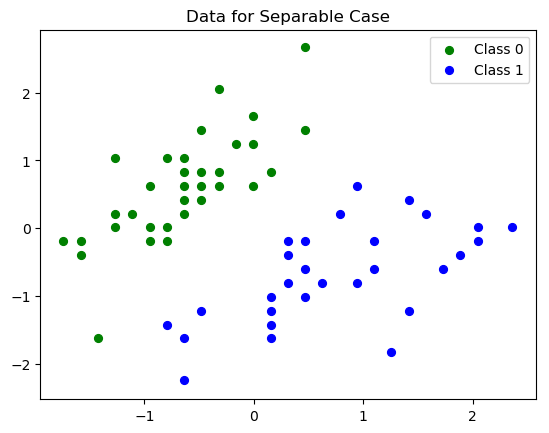

PyObject Text(0.5, 1.0, 'Data for Separable Case')

In [3]:
#---------------------------------------------------------
# Show a 2-dimensional plot for the given features with
# different colors according to the labels.
#---------------------------------------------------------
function showbefore(features::Array{Float64,2},labels::Array{Float64,1})
  idx0 = findall(labels.==0)
  idx1 = findall(labels.==1)
  figure()
  scatter(features[idx0,1],features[idx0,2],s=10pi,c="green")
  scatter(features[idx1,1],features[idx1,2],s=10pi,c="blue")
  legend(["Class 0", "Class 1"])
  return nothing::Nothing
end

# show data points
showbefore(features,labels)
title("Data for Separable Case")

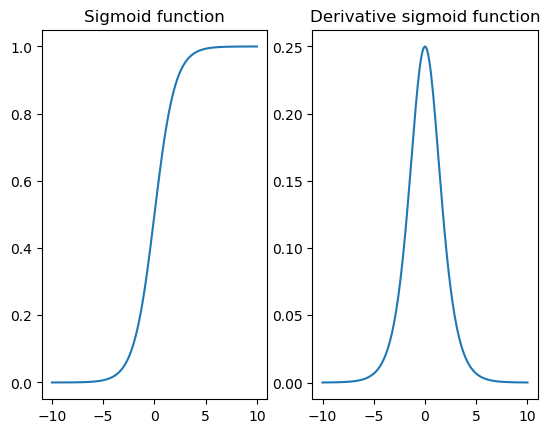

In [4]:
#---------------------------------------------------------
# Implements the sigmoid function.
#---------------------------------------------------------
function sigmoid(z)
  s = (1.0 ./ (1.0 .+ exp.(-z)))
  return s
end


#---------------------------------------------------------
# Implements the derivative of the sigmoid function.
#---------------------------------------------------------
function dsigmoid_dz(z)
  ds = (sigmoid(z) .* (1 .- sigmoid(z)))
  return ds
end

# Illustration of the sigmoid function and its derivative.
x = -10:0.1:10
figure()
subplot(1,2,1), plot(x, sigmoid(x)), title("Sigmoid function");
subplot(1,2,2), plot(x, dsigmoid_dz(x)), title("Derivative sigmoid function");

In [5]:
#---------------------------------------------------------
# Initialize weights and biases from Gaussian distributions
#---------------------------------------------------------
function initWeights(netdefinition::Array{Int,1}, sigmaW::Float64, sigmaB::Float64)
  nlayers = size(netdefinition)[1] - 1
  Ws = []
  bs = []
  for i=1:nlayers
    nin = netdefinition[i]
    nout = netdefinition[i+1]
    W = randn(nin, nout) * sigmaW
    push!(Ws, W)
    b = randn(1, nout) * sigmaB
    push!(bs,b)
  end
  return Ws::Vector{Any}, bs::Vector{Any}
end

#---------------------------------------------------------
# A helper function which decomposes and reshapes weights and biases from the variable theta
#---------------------------------------------------------
function thetaToWeights(theta::Vector{Float64}, netdefinition::Array{Int,1})
  nlayers = size(netdefinition)[1] - 1
  Ws = []
  bs = []
  curj = 1
  for i=1:nlayers
    nin = netdefinition[i]
    nout = netdefinition[i+1]
    W = reshape(theta[curj:curj+nin*nout-1], (nin, nout))
    push!(Ws, W)
    curj += nin*nout
    b = reshape(theta[curj:curj+nout-1], (1, nout))
    push!(bs,b)
    curj += nout
  end
  return Ws::Vector{Any}, bs::Vector{Any}
end

#---------------------------------------------------------
# A helper function which concatenates weights and biases into a variable theta
#---------------------------------------------------------
function weightsToTheta(Ws::Vector{Any}, bs::Vector{Any})
  nlayers = size(Ws)[1]
  thetas = []
  for i=1:nlayers
    push!(thetas, vec(Ws[i]))
    push!(thetas, vec(bs[i]))
  end
  theta = vcat(thetas...)
  return theta::Vector{Float64}
end

# Initialize weights, convert to a single vector and convert back
using Printf
netdefinition = [2, 4, 4, 1]     # compare assignment sheet
Ws_init, bs_init = initWeights(netdefinition, 0.01, 0.001)
println(@sprintf("Shapes Ws_init: %s, %s, %s",size(Ws_init[1]),size(Ws_init[2]),size(Ws_init[3])))
println(@sprintf("Shapes bs_init: %s, %s, %s",size(bs_init[1]),size(bs_init[2]),size(bs_init[3])))
theta = weightsToTheta(Ws_init, bs_init)
println(@sprintf("Shape theta: %s",size(theta)))
Ws_reshaped, bs_reshaped = thetaToWeights(theta, netdefinition)
println(@sprintf("Shapes Ws_reshaped: %s, %s, %s",size(Ws_reshaped[1]),size(Ws_reshaped[2]),size(Ws_reshaped[3])))
println(@sprintf("Shapes bs_reshaped: %s, %s, %s",size(bs_reshaped[1]),size(bs_reshaped[2]),size(bs_reshaped[3])))

Shapes Ws_init: (2, 4), (4, 4), (4, 1)
Shapes bs_init: (1, 4), (1, 4), (1, 1)
Shape theta: (37,)
Shapes Ws_reshaped: (2, 4), (4, 4), (4, 1)
Shapes bs_reshaped: (1, 4), (1, 4), (1, 1)


In [6]:
#---------------------------------------------------------
# Evaluates the loss function of the MLP.
#---------------------------------------------------------
function nnloss(theta::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})
  # weights and biases
  Ws, bs = thetaToWeights(theta, netdefinition)

  # meta
  nlayers = size(Ws)[1]
  n = size(X,2)

  # forward pass
  activations = [X]
  outputs = []
  for i=1:nlayers
    push!(outputs,activations[i]*Ws[i] .+ bs[i])  # linear transform
    push!(activations, sigmoid(outputs[i]))       # nonlinearity
  end
  p = activations[end]

  # binary cross entropy loss
  loss = -mean(y .* log.(p) .+ (1 .- y) .* log.(1 .- p))

  return loss::Float64
end


#---------------------------------------------------------
# Evaluate the gradient of the MLP loss w.r.t. Ws and Bs
# The gradient should be stored in the vector 'storage'
#---------------------------------------------------------
function nnlossgrad(storage::Array{Float64,1}, theta::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})
  # weights and biases
  Ws, bs = thetaToWeights(theta, netdefinition)

  # meta
  nlayers = size(Ws)[1]
  n = size(X,2)

  # forward pass
  activations = [X]
  outputs = []
  for i=1:nlayers
    push!(outputs,activations[i]*Ws[i] .+ bs[i])  # linear transform
    push!(activations, sigmoid(outputs[i]))       # nonlinearity
  end
  p = activations[end]

  # backpropagate loss function
  dloss_dp = -(y ./ p .- (1 .- y)./(1 .- p)) ./ n

  # backpropagate through network
  grad_Ws = Array{Any}(undef, nlayers)
  grad_bs = Array{Any}(undef, nlayers)
  dloss_da = Array{Any}(undef, nlayers+1)
  dloss_da[end] = dloss_dp
  for i=nlayers:-1:1
    dloss_do = dloss_da[i+1] .* dsigmoid_dz(outputs[i])
    grad_Ws[i] = activations[i]' * dloss_do
    grad_bs[i] = sum(dloss_do,dims=1)
    dloss_da[i] = dloss_do * Ws[i]'
  end

  # ..and back to parameter vector
  storage[1:end] = weightsToTheta(grad_Ws, grad_bs)

  return storage::Array{Float64,1}
end


#---------------------------------------------------------
# Use LBFGS to optimize the MLP loss
#---------------------------------------------------------
function train(trainfeatures::Array{Float64,2}, trainlabels::Array{Float64,1}, netdefinition::Array{Int, 1})

  # Randomly initialize weights and biases
  Ws_init, bs_init = initWeights(netdefinition, 0.01, 0.001)

  # concatenate weights and biases into one parameter vector
  theta_init = weightsToTheta(Ws_init,bs_init)

  # loss function
  f(theta) = nnloss(theta, trainfeatures, trainlabels, netdefinition)

  # gradient
  g(storage, theta) = nnlossgrad(storage, theta, trainfeatures, trainlabels, netdefinition)

  # run optimizer
  res = optimize(f, g, theta_init, LBFGS(), Optim.Options(iterations=10000, show_trace=true))

  # get result
  theta = Optim.minimizer(res)

  # ..and back to weights and biases
  Ws, bs = thetaToWeights(theta, netdefinition)

  return Ws::Vector{Any},bs::Vector{Any}
end

# make results reproducable
Random.seed!(10)
# train MLP
Ws,bs = train(features, labels, [2,4,1]);

Iter     Function value   Gradient norm 
     0     6.929603e-01     9.610835e-01
     1     6.910887e-01     3.433003e-01
     2     6.906667e-01     1.576070e-01
     3     1.143037e-01     9.140521e-01
     4     2.456680e-06     7.615688e-05
     5     1.038596e-16     3.219647e-15


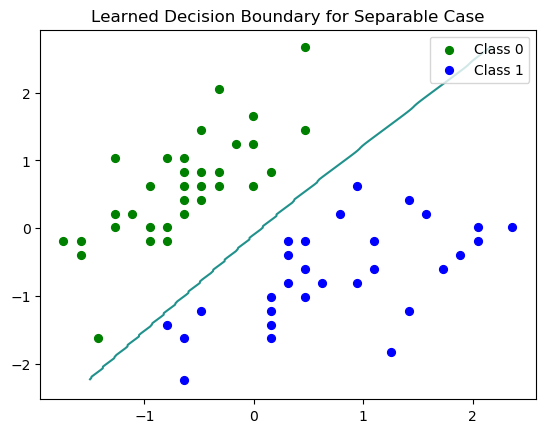

PyObject Text(0.5, 1.0, 'Learned Decision Boundary for Separable Case')

In [7]:
#---------------------------------------------------------
# Predict the classes of the given data points using Ws and Bs.
# p, N x 1 array of Array{Float,2}, contains the output class scores (continuous value) for each input feature.
# c, N x 1 array of Array{Float,2}, contains the output class label (either 0 or 1) for each input feature.
#---------------------------------------------------------
function predict(X::Array{Float64,2}, Ws::Vector{Any}, bs::Vector{Any})
  nlayers = size(Ws)[1]
  n = size(X,2)

  activations = [X]
  outputs = []
  for i=1:nlayers
    push!(outputs,activations[i]*Ws[i] .+ bs[i])
    push!(activations, sigmoid(outputs[i]))
  end

  p = activations[end]
  c = zeros(size(p))
  c[p.>0.5] .= 1.0

  return p::Array{Float64,2}, c::Array{Float64,2}
end

#---------------------------------------------------------
# Show a 2-dimensional plot for the given features along
# with the decision boundary.
#---------------------------------------------------------
function showafter(features::Array{Float64,2},labels::Array{Float64,1},Ws::Vector{Any}, bs::Vector{Any})
  showbefore(features,labels)
  xmin = minimum(features[:,1])
  xmax = maximum(features[:,1])
  ymin = minimum(features[:,2])
  ymax = maximum(features[:,2])

  xx, yy = Common.meshgrid(range(xmin,stop=xmax,length=200), range(ymin,stop=ymax,length=200))
  p,_ = predict(hcat(xx[:], yy[:]), Ws, bs)
  p = reshape(p, size(xx))

  contour(xx, yy, p, 1)

  return nothing::Nothing
end

# show optimum and plot decision boundary
showafter(features,labels,Ws,bs)
title("Learned Decision Boundary for Separable Case")

Iter     Function value   Gradient norm 
     0     6.932620e-01     1.026647e+00
     1     6.912687e-01     3.453896e-01
     2     6.908983e-01     1.164328e-01
     3     3.726400e-01     2.969324e+00
     4     3.335723e-01     4.999364e-01
     5     1.939533e-01     3.068164e-01
     6     1.905009e-01     3.032353e-01
     7     1.856208e-01     1.881263e-01
     8     1.840403e-01     2.142142e-01
     9     1.830742e-01     7.246835e-02
    10     1.828416e-01     1.034506e-01
    11     1.806302e-01     6.067114e-02
    12     1.802591e-01     6.970223e-02
    13     1.792998e-01     1.856112e-01
    14     1.758810e-01     1.925624e-01
    15     1.746536e-01     2.619441e-01
    16     1.693245e-01     2.884689e-01
    17     1.664509e-01     6.198925e-02
    18     1.654086e-01     1.012622e-01
    19     1.638918e-01     1.597711e-01
    20     1.631886e-01     8.749269e-02
    21     1.598742e-01     1.121819e-01
    22     1.591895e-01     1.300653e-01
    23     1.549

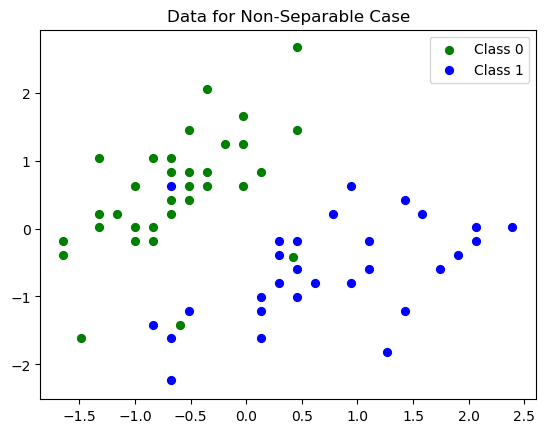

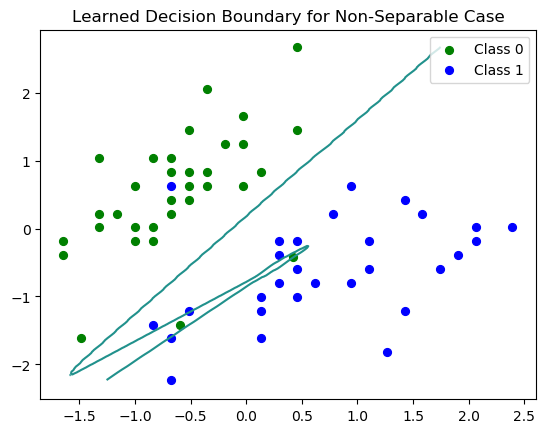

In [8]:
# load linear non-separable data
features2,labels2 = loaddata("nonseparable.jld2")

# show data points
showbefore(features2,labels2)
title("Data for Non-Separable Case")

# train MLP
Ws,bs = train(features2,labels2, [2,4,1])

# show optimum and plot decision boundary
showafter(features2,labels2,Ws, bs)
title("Learned Decision Boundary for Non-Separable Case");

In [9]:
# PLANE-BIKE-CLASSIFICATION FROM PROBLEM 1
# load data
trainfeatures,trainlabels = loaddata("imgstrain.jld2")
testfeatures,testlabels = loaddata("imgstest.jld2")

# train MLP and predict classes
Ws,bs = train(trainfeatures,trainlabels, [50,20,10,1])
_,trainpredictions = predict(trainfeatures, Ws, bs)
_,testpredictions = predict(testfeatures, Ws, bs)

# show error
trainerror = sum(trainpredictions.!=trainlabels)/length(trainlabels)
testerror = sum(testpredictions.!=testlabels)/length(testlabels)
println("Training Error Rate: $(round(100*trainerror,digits=2))%")
println("Testing Error Rate: $(round(100*testerror,digits=2))%")

Iter     Function value   Gradient norm 
     0     6.944593e-01     1.529015e-01
     1     6.863284e-01     2.597524e-03
     2     6.863261e-01     6.487861e-06
     3     6.733672e-01     1.683779e-01
     4     6.572220e-01     2.584774e-01
     5     6.262269e-01     1.204126e-01
     6     1.924477e-01     6.071641e-01
     7     7.093614e-02     9.013069e-02
     8     6.672954e-02     2.246089e-02
     9     4.162119e-02     1.643939e-01
    10     3.263248e-02     5.695036e-02
    11     2.639346e-02     4.245306e-02
    12     2.434408e-02     1.136199e-01
    13     1.272564e-02     6.638837e-02
    14     1.801185e-03     1.597652e-02
    15     1.749780e-04     2.458142e-03
    16     4.715546e-05     2.389471e-04
    17     2.508627e-05     1.285491e-04
    18     1.360761e-05     1.126774e-04
    19     9.441035e-06     1.698574e-05
    20     1.862406e-06     7.753833e-05
    21     1.185371e-07     1.229189e-06
    22     3.579523e-08     2.265299e-07
    23     2.284